# Useful Functions

https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

In [1]:
# Function to assess model and visualize output
def model_assessment(train, test, predictions, chart_title):
  # Set the size of the plot to 10 inches by 4 inches
  plt.figure(figsize = (10,4))
  # Plot the train, test, and forecast data
  plt.plot(train, label = 'Train')
  plt.plot(test, label = 'Test')
  plt.plot(predictions, label = "Forecast")
  # add title and legend to the plot
  plt.title(f"Train, Test and Predictions with {chart_title}")
  plt.legend()
  plt.show()

  # Calculating the MAE, RMSE, and MAPE
  mae = mean_absolute_error(test, predictions)
  rmse = root_mean_squared_error(test, predictions)
  mape = mean_absolute_percentage_error(test, predictions)

  # Print the calculated error metrics
  print(f"The MAE is {mae:.2f}")
  print(f"The RMSE is {rmse:.2f}")
  print(f"The MAPE is {100 * mape:.2f} %")

In [2]:
# Function to plot the future
def plot_future(y, forecast, title):
  # Set the size of the plot to 10 inches by 4 inches
  plt.figure(figsize = (10,4))
  # Plot the train and forecast data
  plt.plot(y, label = 'Train')
  plt.plot(forecast, label = "Forecast")
  # add title and legend to the plot
  plt.title(f"Train and Forecast with {title}")
  plt.legend()
  plt.show()

# Libraries and Data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd /content/drive/MyDrive/Python - Time Series Forecasting/Time Series Analysis/ARIMA, SARIMA and SARIMAX

/content/drive/MyDrive/Python - Time Series Forecasting/Time Series Analysis/ARIMA, SARIMA and SARIMAX


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import (
    month_plot,
    quarter_plot,
    plot_acf,
    plot_pacf
)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import (
    mean_absolute_error,
    root_mean_squared_error,
    mean_absolute_percentage_error)
from sklearn.model_selection import ParameterGrid
import numpy as np

In [8]:
# Loading the daily revenue data and set the date as uindex
df = pd.read_csv("daily_revenue.csv",
                 index_col = "date",
                 parse_dates = True,
                 dayfirst = True)
df.head()

,revenue,discount_rate,coupon_rate
date,,,
2018-01-01,"6,270,839",34.27%,1.09%
2018-01-02,"8,922,076",30.87%,1.08%
2018-01-03,"8,446,101",28.11%,1.01%
2018-01-04,"7,785,798",27.32%,0.96%
2018-01-05,"6,375,303",25.70%,0.90%


In [ ]:
# Information about the df
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1795 entries, 2018-01-01 to 2022-11-30
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   revenue        1795 non-null   object
 1   discount_rate  1795 non-null   object
 2   coupon_rate    1795 non-null   object
dtypes: object(3)
memory usage: 56.1+ KB


In [ ]:
# Remove the comma in revenue and convert it as float
df['revenue'] = df['revenue'].str.replace(",", "").astype(float)

In [ ]:
# Set the dataframe to have daily frequency
df = df.asfreq("D")

In [ ]:
# Change the time Series variable name
df = df.rename(columns = {'revenue': 'y'})
df.head()

,y,discount_rate,coupon_rate
date,,,
2018-01-01,6270839.0,34.27%,1.09%
2018-01-02,8922076.0,30.87%,1.08%
2018-01-03,8446101.0,28.11%,1.01%
2018-01-04,7785798.0,27.32%,0.96%
2018-01-05,6375303.0,25.70%,0.90%


A list of commonly used `.asfreq()` aliases:

Time-based frequencies:

- 'D': Calendar day frequency
- 'B': Business day frequency
- 'W': Weekly frequency
- 'W-MON', 'W-TUE', ..., 'W-SUN': Weekly frequency (anchored on a specific day)
- 'ME': Month end frequency
- 'MS': Month start frequency
- 'Q': Quarter end frequency
- 'QS': Quarter start frequency
- 'A' or 'Y': Year end frequency
- 'BA' or 'BY': Business year end frequency
- 'AS' or 'YS': Year start frequency
- 'BAS' or 'BYS': Business year start frequency


Hourly, minutely, and secondly frequencies:

- 'H': Hourly frequency
- 'T' or 'min': Minutely frequency
- 'S': Secondly frequency


You can also use multiples, like:

- '2D': Every 2 days
- '4H': Every 4 hours
- '15T' or '15min': Every 15 minutes

# Exploratory Data Analysis

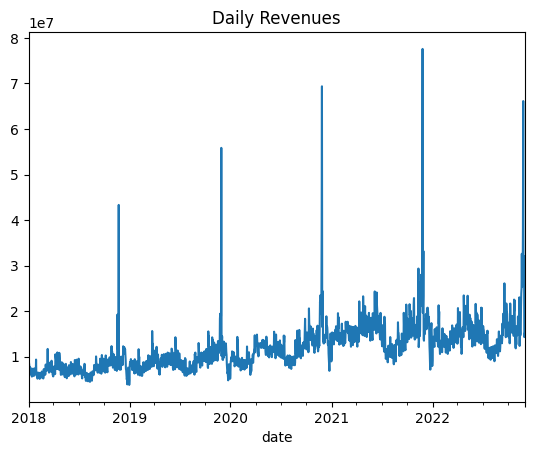

In [ ]:
# Daily revenues line plot
df['y'].plot(title = 'Daily Revenues')
plt.show()

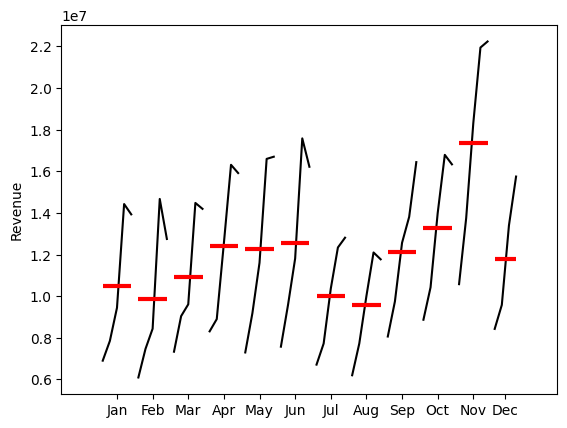

In [ ]:
# month_plot() - To visualize the average value for each month across multiple years in a time series
# red lines - Represents the mean value for each month

# Plotting the monthly seasonality of revenue values
month_plot(df['y'].resample('ME').mean(),
           ylabel = 'Revenue')
plt.show()

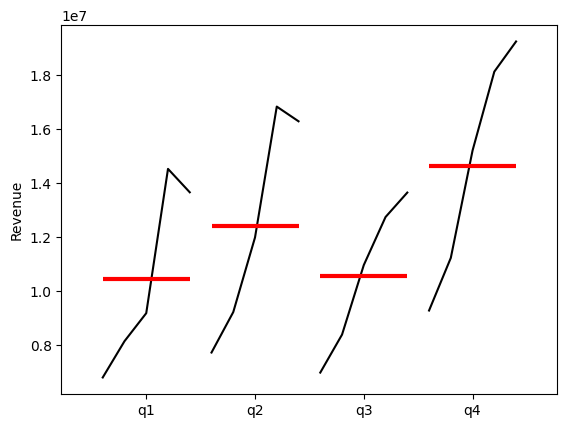

In [ ]:
# quarter_plot() - To visualize seasonal patterns at a quarterly level.
# Q1 (january, february, march), Q2 (april, may, june), Q3 (july, august, september), Q4 (october, november, december)

# Plotting the quarterly seasonality of revenue values
# .resample('Q') - to convert the time series data into quarterly seasonality
quarter_plot(df['y'].resample('QE').mean(),
           ylabel = 'Revenue')
plt.show()

`seasonal_decompose` - To decompose a time series into its constituent parts to better understand the underlying patterns.

components

- Trend: The overall direction of the series (increasing, decreasing, or stable).
- Seasonal: Repeating patterns at fixed intervals (e.g., daily, weekly, monthly).
- Residual: The remaining variation after removing trend and seasonal components.

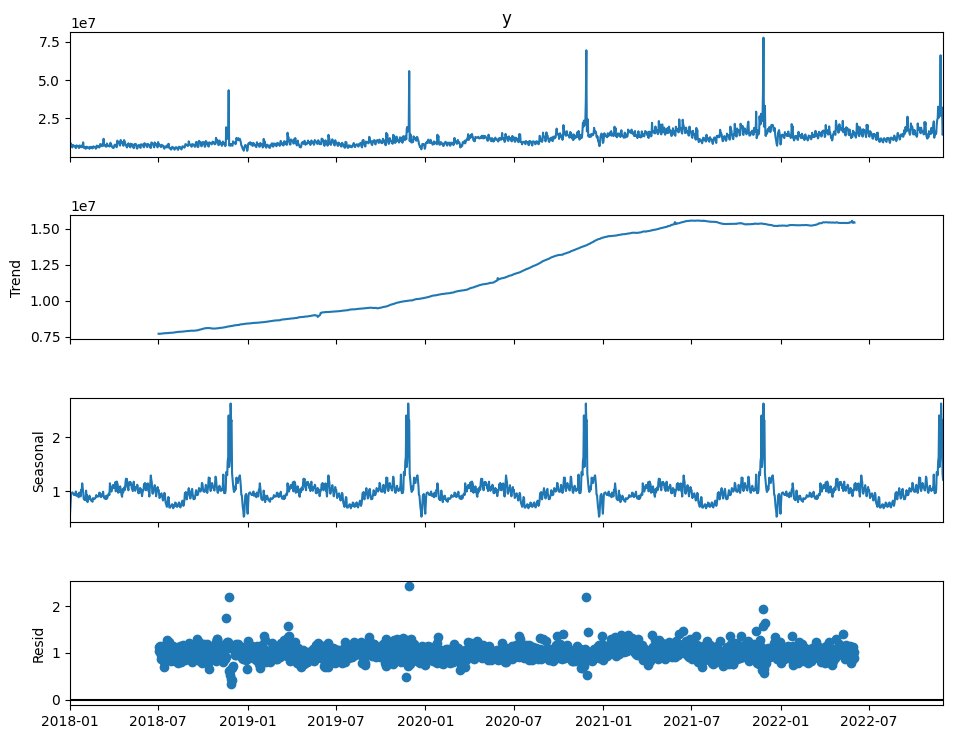

In [ ]:
# Seasonal Decomposition Plots for Revenue Data
# Multiplicative model type, with daily seasonality (365 days)
decomposition = seasonal_decompose(df['y'],
                                   model = 'mul',
                                   period = 365)
fig = decomposition.plot()
fig.set_size_inches(10,8)
plt.show()

Autocorrelation measures the correlation between a time series and a lagged version of itself.

Purpose: To identify patterns or repeating cycles in a time series dataset.

Interpretation:
- Values range from -1 to 1.
- 1 indicates perfect positive correlation.
- -1 indicates perfect negative correlation.
- 0 indicates no correlation.

ACF Plot:
- X-axis: Lag periods
- Y-axis: Correlation coefficient

Key Features:
- At lag 0, autocorrelation is always 1 (a series is perfectly correlated with itself).
- Significant spikes at certain lags indicate repeating patterns.


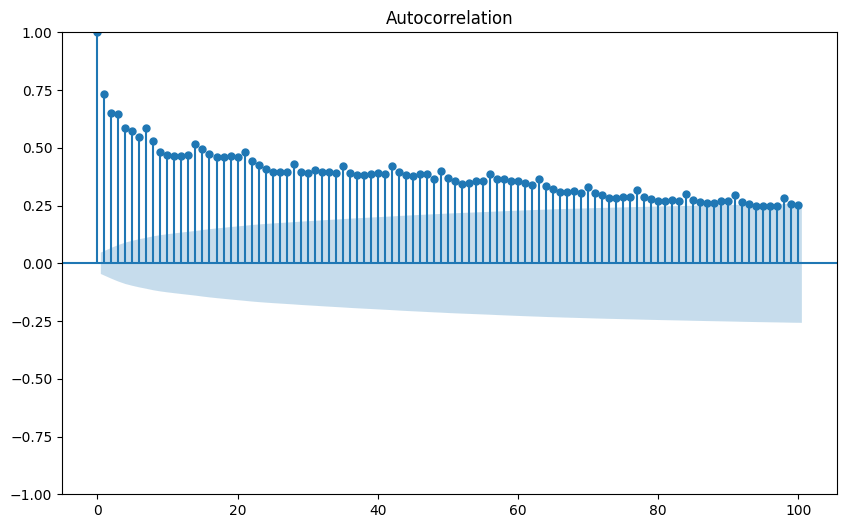

In [ ]:
# Plot the autocorrelation (ACF) of revenue values
fig, ax = plt.subplots(figsize = (10,6))
plot_acf(df['y'], lags = 100, ax = ax)
plt.show()

PACF measures the correlation between a time series and its lag, after removing the effects of all shorter lags.

Purpose: To identify the direct relationship between an observation and its lag, without intermediate effects.

Main Difference between ACF and PACF:
- ACF: Measures overall correlation at each lag, including indirect effects.
- PACF: Measures direct correlation at each lag, excluding indirect effects.

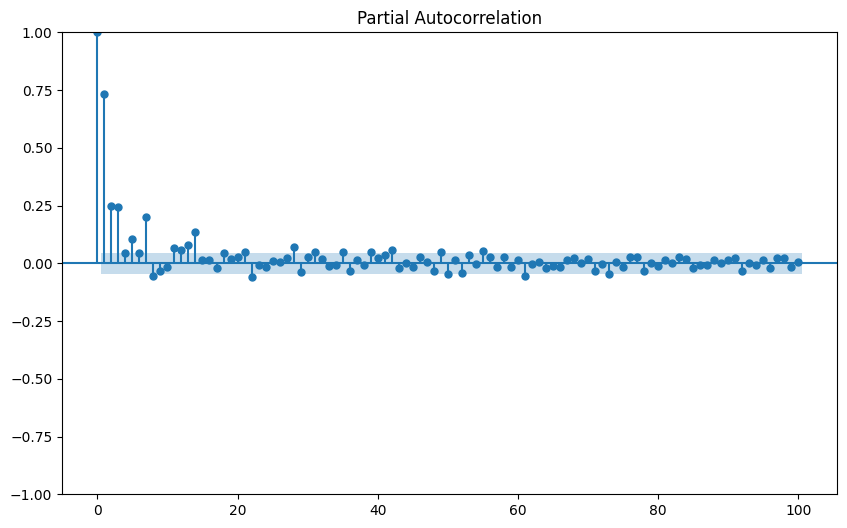

In [ ]:
# Plot the partial autocorrelation (PACF) of revenue values
fig, ax = plt.subplots(figsize = (10,6))
plot_pacf(df['y'], lags = 100, ax = ax)
plt.show()

# Stationarity